# Efecto del Aprendizaje en Línea en el Desempeño de Modelos con Distintos Perfiles de Sesgo y Varianza

## Objetivo

Evaluar como el aprendizaje en línea modifica el rendimiento y la estabilidad de modelos de distinto sesgo/variance, comparandolo con aprendizaje por lotes (batch), bajo escenarios estacionarios y no estacionarios (concept draft)

## Importancia de On Line Learning

En la vida real, las propiedades estadísticas de la variable objetivo cambian con el tiempo. Lo que invalida el aprendizaje de cualquier modelo, llevando a caidas en la precisión de la predicción.

En terminos simples, esto quiere decir que el "concepto" o los patrones que el modelo de Machine Learning originalmente aprendió ya no reflejan la realidad actual de los datos. Esto pasa en distintos escenarios de la vida real donde el entorno o el comportamiento que fueron modelado evoluciona.

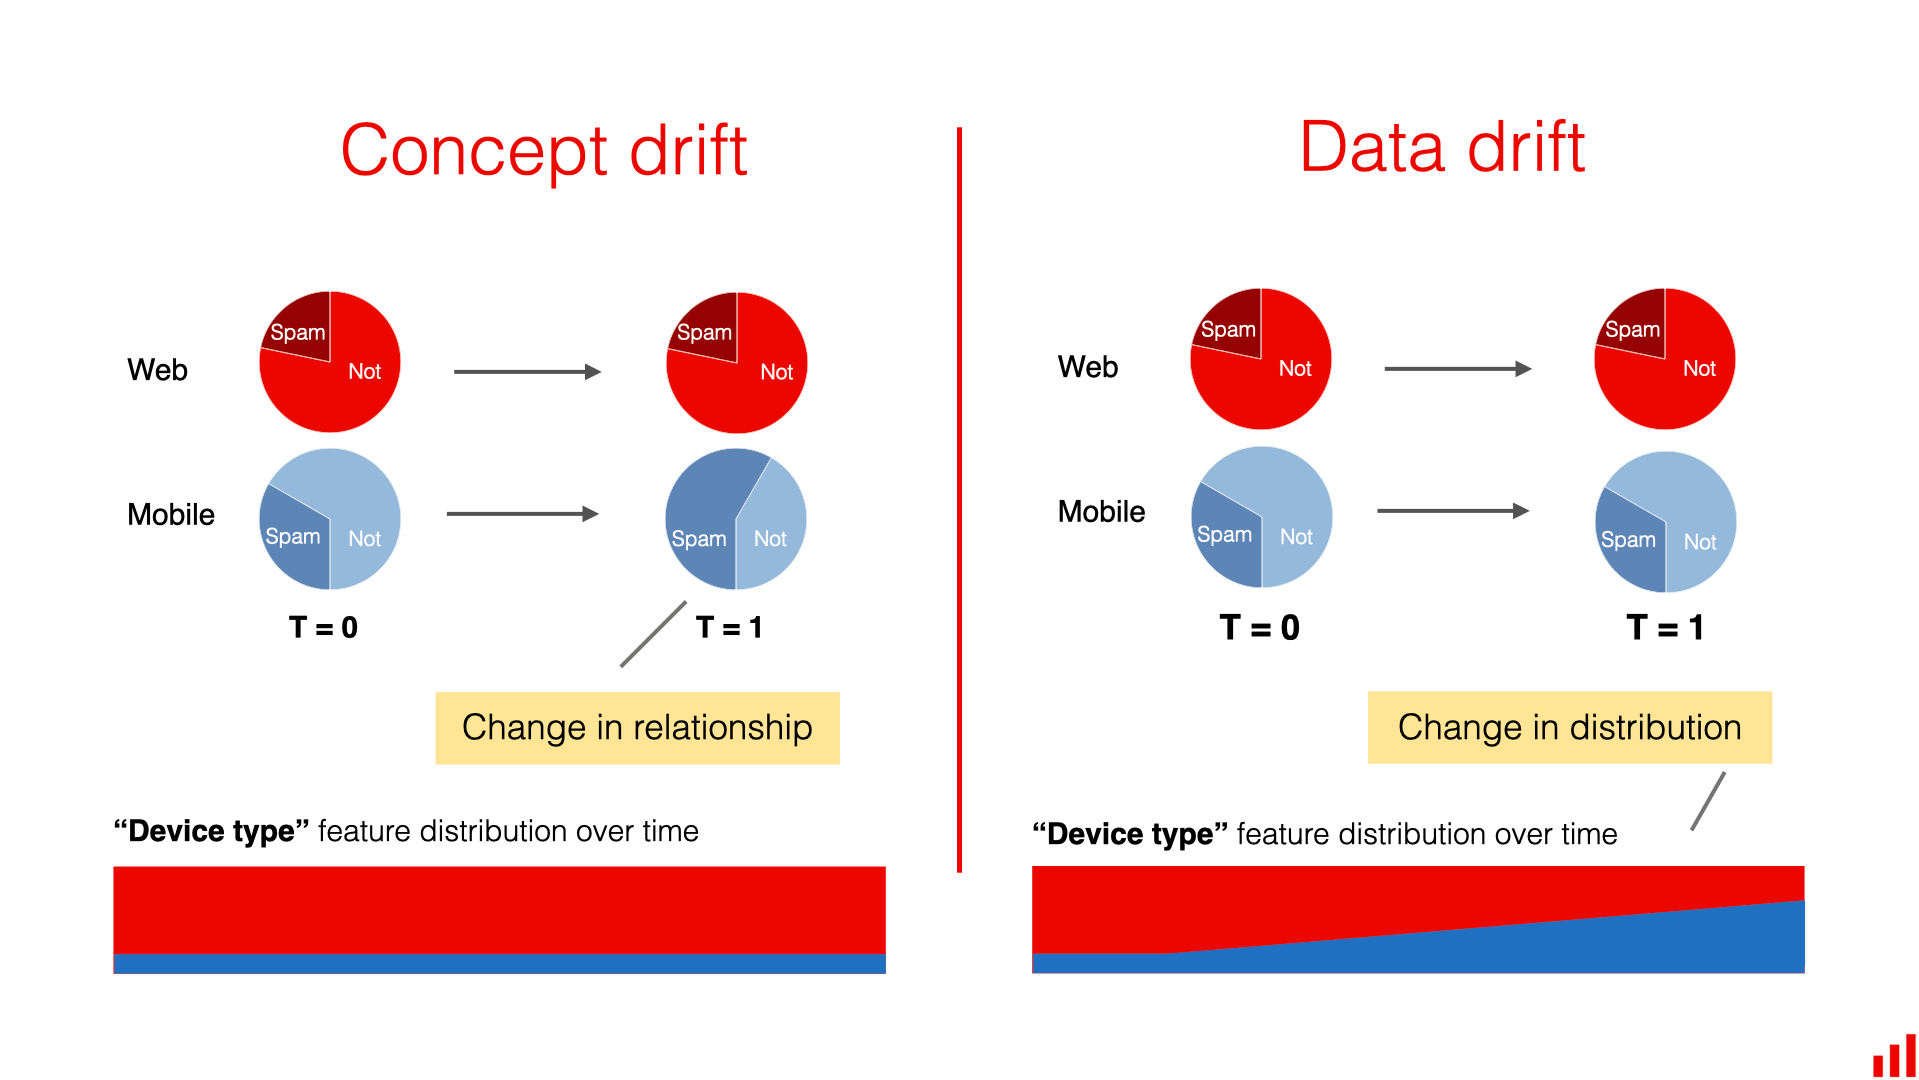

Estos cambios de comportamiento suelen llamarse **drift** y hay distintos tipos:

- **Sudden dift:** Cambios abruptos y significativos en el concepto.
- **Gradual drift:** Cambios lentos y paulatinos en el concepto a través del tiempo.
- **Recurrent drift:** Cambios que tienden a regresar a conceptos observados anteriormente.
- **Incremental drift:** Una serie de cambios pequeños que se van acumulando con el tiempo.

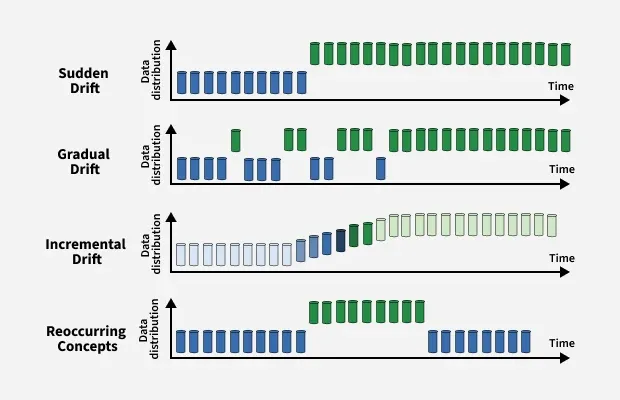

Existen distintas formas de solventar los cambios de concepto:

- **Detección de drift:** Identificar las variables que estén causando drift en el concepto.
- **Adaptación del modelo:** Re-entrenar los modelos cada vez que se detecta una caida en el desempeño de los modelos.
- **Entendimiento de la causa raíz:** Identificar la causa raíz y crear catacterísticas/variables que sean capaces de capturar estos efectos para modelarlos.

El aprendizaje en línea adapta los modelos en cada nueva iteración de predicción, siguiendo la siguiente lógica:

```
1. Transforma el input
2. Predice el valor del patrón de entrada
3. Aprende sobre el patrón de entrada
```

**¿Por qué primero predice y luego aprende?** Esto se hace porque, en un escenario real, no conocemos aún el valor real de la entrada, por lo que no es posible pasar a una fase de aprendizaje. Una vez se confirma el valor real, entonces podemos pasar a la gase de aprendizaje del patrón predicho y obtener un score.

>**NOTA IMPORTANTE**
>
>Ninguno de los algoritmos mostrados aquí tuvo ajuste fino, se tuvo la precaución de mantenerlos en su versión más vanilla para poder hacer una comparativa justa.
>
>Tampoco hubo un trabajo muy profundo en tratamiento de datos y, por cada algoritmo, se mantiene una versión compatible de los mismos tratamiento, haciendo que todos compartan características.
>
>No se comparten pipelines de tratamiento de datos ni entre algoritmos de scikit-learn, tampoco entre algoritmos de river y tampoco cruzado. Hay una limitante en cuanto a los algoritmos que son compatibles entre ambas librerías y, en muchas ocasiones, la compatibilidad trae problemas difíciles de corregir.

## Recordatorio: Sesgo vs Varianza

**Sesgo (Bias):** El error que introduce el modelo al simplificar demasiado la realidad (subajuste). Un modelo con alto sesgo no captura las relaciones complejas en los datos.

**Varianza (Variance):** La sensibilidad del modelo a las pequeñas fluctuaciones en el conjunto de datos de entrenamiento (sobreajuste). Un modelo con alta varianza captura el "ruido" en lugar de la "señal".

Cada modelo de machine learning tiende más al sesgo o a la varianza, dependiendo de cada algoritmos.

Por ejemplo, la regresión lineal es un modelo de alto sesgo y baja varianza, esto quiere decir que el modelo es muy estable y consistente (alto sesgo), pero es muy rígico (baja varianza). Lo que provoca que tenga problemas de generalización para problemas complejos.

Por otro lado, un árbol de decisión tiene bajo sesgo y alta varianza, lo que se traduce en un modelo que tiene la capacidad de generalizar adecuadamente los problemas (alta varianza), pero no es estable, ni consistente (bajo sesgo).
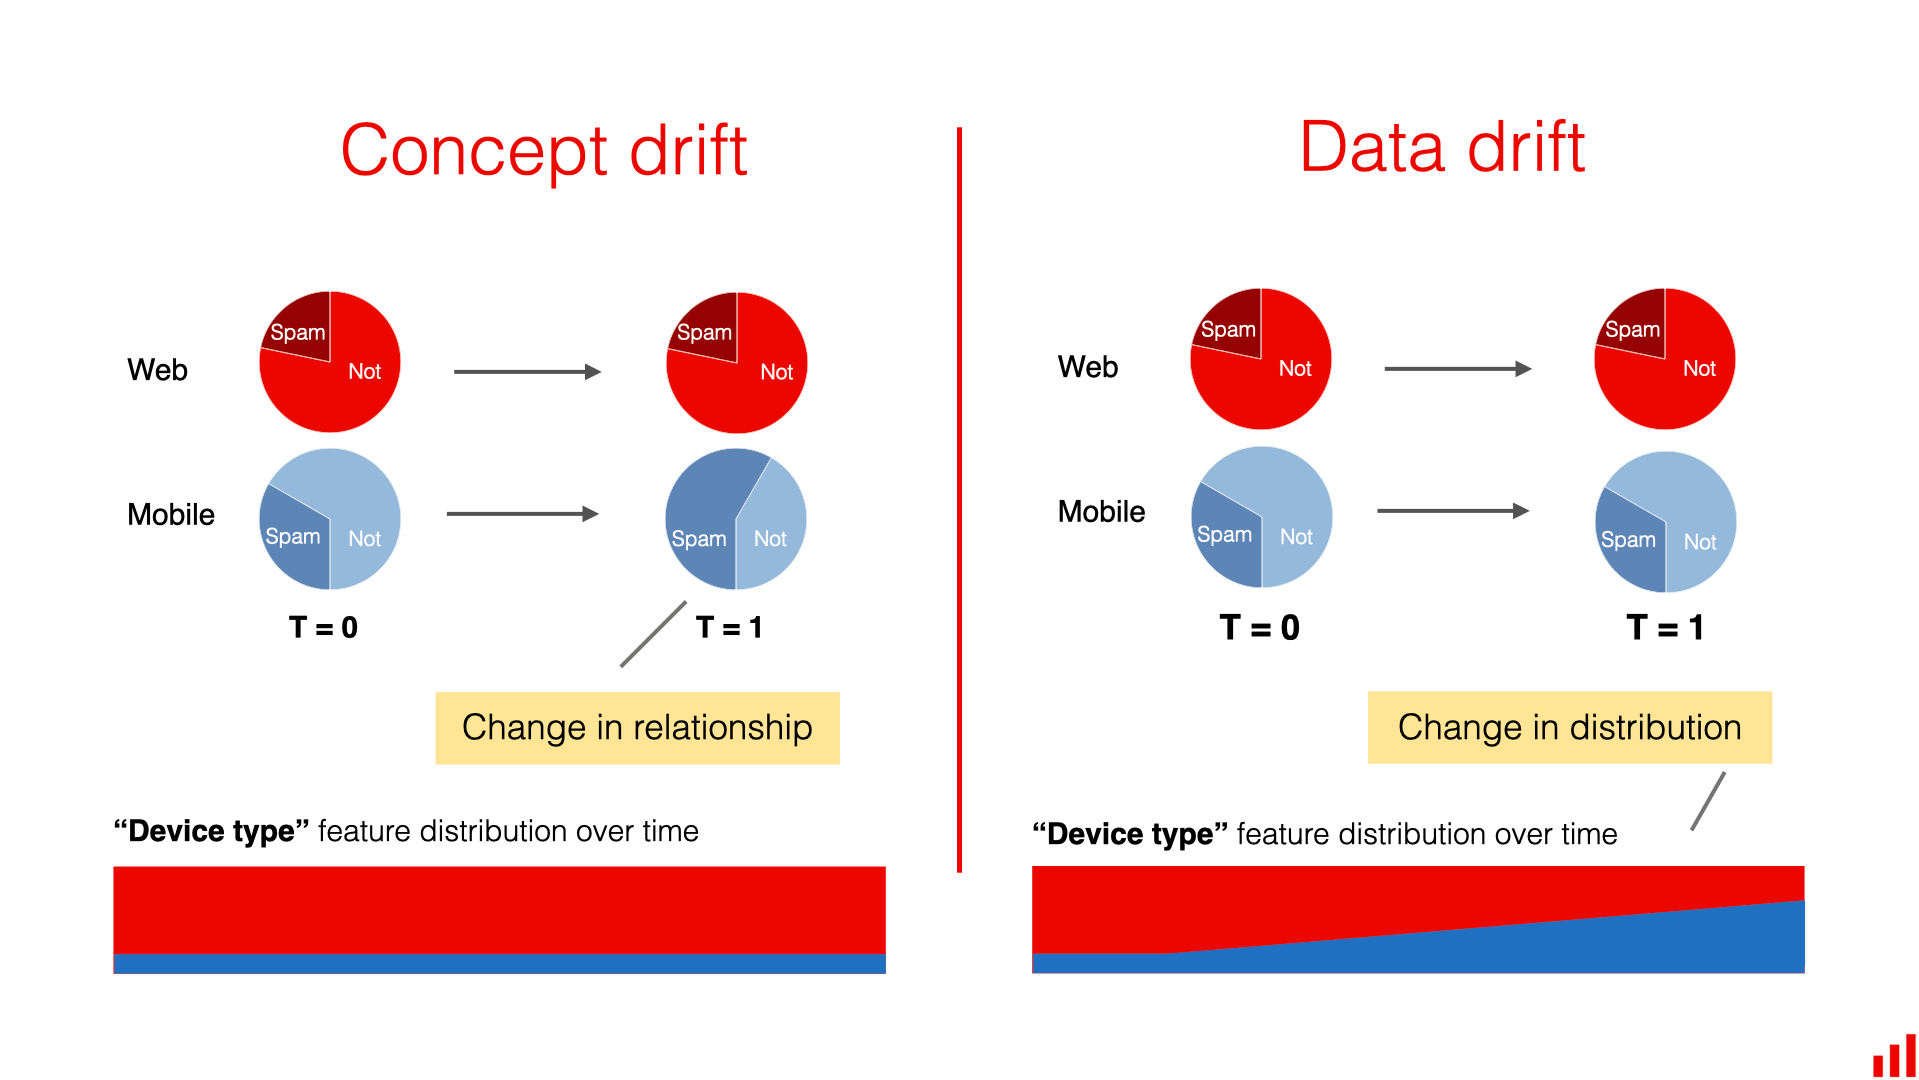
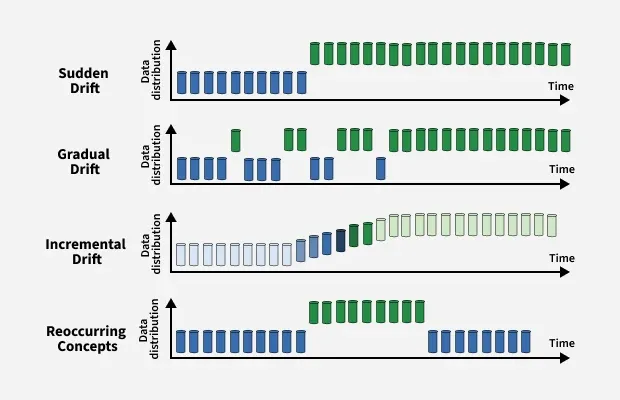

In [1]:
! pip install river

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 3.0 MB/s eta 0:00:0000:01:00:01


# Importación de librerias

Hay dos librerías importantes aquí, `scikit-learn` y `river`.

Scikit-learn se utiliza para aprendizaje en lotes (aunque también tiene implementaciones de aprendizaje en línea)

River es una librería especializada para aprendizaje en línea, con algoritmos adaptados a este tipo de aprendizaje.

In [2]:
import pandas as pd
import numpy as np

from sklearn import datasets
from sklearn import linear_model
from sklearn import ensemble
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
from sklearn import compose
from sklearn import feature_extraction
from sklearn import tree

from river import stream, optim
from river import linear_model as river_lm
from river import compose as river_compose
from river import preprocessing as river_preprocessing
from river import compat as river_compat
from river import feature_extraction as rfe
from river import tree as river_tree
from river import ensemble as river_ensemble
from river import metrics as river_metrics
from river import evaluate as river_eval

from category_encoders import WOEEncoder
import xgboost as xgb

# Suprimir warning del output para no ensuciar la vista de resultados
import warnings
warnings.filterwarnings(action='ignore')

# Lectura de fuente de datos

In [ ]:
df = pd.read_csv(
    "/kaggle/input/vehicle-claim-fraud-detection/fraud_oracle.csv"
)

df.head()

## Preparación del dataset

Se prepara la información se la siguiente manera

1. Se separan las variables que son binarias y se convierten.
2. Las columnas de fecha se convierten a números.
3. Se remueven los registros que no coinciden con este formato (al momento de la exploración, solamente se detecta un registro con estas características)
4. Se separa la variable objetivo de las variables predictoras.

In [ ]:
encoder_sex = {"Male":0, "Female":1}
encoder_accident_area = {"Urban":0, "Rural":1}
encoder_fault = {"Policy Holder":0, "Third Party":1}
encoder_agent_type = {"External":0, "Internal":1}
encoder_police_report = {"No":0, "Yes":1}
encoder_witness_present = {"No":0, "Yes":1}

encoder_month = {"Jan":1,"Feb":2,"Mar":3,"Apr":4,"May":5,"Jun":6,
                 "Jul":7,"Aug":8,"Sep":9,"Oct":10,"Nov":11,"Dec":12}
encoder_week = {'Monday': 1,'Tuesday': 2,'Wednesday': 3, 'Thursday': 4,
                'Friday': 5,'Saturday': 6,'Sunday': 7,}

df = df.query("DayOfWeekClaimed != '0'")

y = df[["FraudFound_P"]]
X = df.drop(columns="FraudFound_P")

X = X.assign(
    Sex = lambda df: df.Sex.map(encoder_sex),
    AccidentArea = lambda df: df.AccidentArea.map(encoder_accident_area),
    Fault = lambda df: df.Fault.map(encoder_fault),
    AgentType = lambda df: df.AgentType.map(encoder_agent_type),
    PoliceReportFiled = lambda df: df.PoliceReportFiled.map(encoder_police_report),
    WitnessPresent = lambda df: df.WitnessPresent.map(encoder_witness_present),
    Month = lambda df: df.Month.map(encoder_month),
    MonthClaimed = lambda df: df.MonthClaimed.map(encoder_month),
    DayOfWeek = lambda df: df.DayOfWeek.map(encoder_week),
    DayOfWeekClaimed = lambda df: df.DayOfWeekClaimed.map(encoder_week)
)

In [ ]:
# Variables binarias
binary_features = ["Sex","AccidentArea","Fault","AgentType","PoliceReportFiled","WitnessPresent"]

# Variables con hasta 5 valores únicos
# Deductible es una variable numérica, pero tiene 5 valores únicos. Como no se esperan valores continuos, entonces
# se trata como una variable categórica
categorical_features = ["MaritalStatus","VehicleCategory","BasePolicy","Year","Days_Policy_Claim",
                        "Days_Policy_Accident","PastNumberOfClaims","NumberOfSuppliments",
                        "AddressChange_Claim","NumberOfCars","Deductible"]

# Variables numéricas
numerical_features = ["Age"]

# Variables de alta dimensionalidad, estas son columnas con más de 5 valores únicos
high_dimensional_features = ["Make","PolicyType","VehiclePrice","AgeOfVehicle","AgeOfPolicyHolder"]

# Variables de fecha o cíclicas
date_features = ["Month","DayOfWeek","DayOfWeekClaimed","MonthClaimed","WeekOfMonthClaimed","WeekOfMonth"]

# Variables de las que se desconoce su naturaleza, estas NO son consideradas en el modelado
unkown_features = ["RepNumber","PolicyNumber"]

In [ ]:
def cyclic_date_encoding(X):
    """Función para codificar las variables cíclicas (o de fechas)
    Con esta función se captura la naturaleza cíclica de las fechas
    utilizando las funciones de seno y coseno
    """
    results = []
    for col in X.columns:
        if col in ["Month","MonthClaimed"]:
            max_val = 12
        elif col in ["DayOfWeek","DayOfWeekClaimed"]:
            max_val = 7
        elif col in ["WeekOfMonthClaimed","WeekOfMonth"]:
            max_val = 5

        sin_val = np.sin(2 * np.pi * X[col] / max_val)
        cos_val = np.cos(2 * np.pi * X[col] / max_val)
        results.extend([sin_val, cos_val])

    return np.column_stack(results)

In [ ]:
def hasher_transform(X: pd.DataFrame):
    fh = feature_extraction.FeatureHasher(n_features=5, input_type="string")
    # convertir cada valor a string porque FH espera texto
    X_str = X.astype(str).to_dict(orient="records")
    return fh.transform(X_str).toarray()

# Entrenamiento

## Modelos de Alto Sesgo y Baja Varianza

### Aprendizaje por Lotes

Para este primer ejercicio, se toma el modelo de regresión logística sin características polinómicas.

> ¿Qué son las características polinómicas y por qué no se toman en cuenta?
>
> Las variables polinómicas ayudan a los modelos lineales a aprender fronteras de decisión no lineales. Esto es, capturar relaciones complejas (o no lineales), lo que mejora la precisión del modelo.
>
> Al ampliar su frontera de decisión aumentamos su varianza mientras reducimos sus sesgo, al agregar técnicas de regularización y escalado de variables, equilibramos el modelo aumentando ligeramente el sesgo y reduciendo la varianza. Evitando que este tenga problemas de sobre ajuste.

In [ ]:
# Pipeline de transformación por columna
ct = compose.ColumnTransformer(
    [("binary_features", "passthrough", binary_features),
     ("categorical_features", preprocessing.OneHotEncoder(), categorical_features),
     ("numerical_features", preprocessing.StandardScaler(), numerical_features),
     ("high_dimensional_features", preprocessing.FunctionTransformer(hasher_transform, validate=False), high_dimensional_features),
     ("date_features", preprocessing.FunctionTransformer(cyclic_date_encoding), date_features)],
    remainder="drop"
)

# Pipeline de entrenamiento por lotes (batch)
lr_model = pipeline.Pipeline([
    ("transformer", ct),
    ("model", linear_model.LogisticRegression(solver="lbfgs"))
])

cv = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
scorer = metrics.make_scorer(metrics.roc_auc_score)
scores = model_selection.cross_val_score(lr_model, X, y, scoring=scorer, cv=cv)

LR_ROC_AUC_BATCH = scores.mean()

### Aprendizaje en línea

El pipeline de tratamiento de datos hace la mismas transformaciones que el pipeline de aprendizaje por lotes.

In [ ]:
def cyclic_date_encoding_river(X):
    """Función para codificar las variables cíclicas (o de fechas)
    Con esta función se captura la naturaleza cíclica de las fechas
    utilizando las funciones de seno y coseno
    """
    results = {}
    
    for col in X.keys():
        if col in ["Month","MonthClaimed"]:
            max_val = 12
        elif col in ["DayOfWeek","DayOfWeekClaimed"]:
            max_val = 7
        elif col in ["WeekOfMonthClaimed","WeekOfMonth"]:
            max_val = 5
        else:
            continue

        sin_val = np.sin(2 * np.pi * X[col] / max_val)
        cos_val = np.cos(2 * np.pi * X[col] / max_val)
        results[col+f"_{X[col]}_sin"] = sin_val
        results[col+f"_{X[col]}_cos"] = cos_val

    
    return results

In [ ]:
numerical_pipe = river_compose.Select("Age") | river_preprocessing.StandardScaler()
categorical_pipe = river_compose.Select(*(categorical_features+high_dimensional_features)) | river_preprocessing.OneHotEncoder()
high_dim_pipe = river_compose.Select(*high_dimensional_features) | river_preprocessing.FeatureHasher(n_features=5, seed=42)
date_pipe = river_compose.Select(*date_features) | river_compose.FuncTransformer(cyclic_date_encoding_river)

transformer = numerical_pipe + categorical_pipe + date_pipe + high_dim_pipe

log_reg = river_lm.LogisticRegression()

y_true = []
y_pred = []

for xi, yi in stream.iter_pandas(X, y.FraudFound_P):
    transformer.learn_one(xi)
    xi_transformed = transformer.transform_one(xi)

    yi_pred = log_reg.predict_proba_one(xi_transformed)
    log_reg.learn_one(xi_transformed, yi)

    y_true.append(yi)
    y_pred.append(yi_pred[True])

# print(f"ROC AUC: {metrics.roc_auc_score(y_true, y_pred):.3f}")
LR_ROC_AUC_ONLINE = metrics.roc_auc_score(y_true, y_pred)

## Modelo de Bajo Sesgo y Alta Varianza

### Aprendizaje por lotes

In [ ]:
# Pipeline de transformación por columna
ct = compose.ColumnTransformer(
    [("binary_features", "passthrough", binary_features),
     ("categorical_features", preprocessing.OneHotEncoder(), categorical_features),
     ("numerical_features", preprocessing.StandardScaler(), numerical_features),
     ("high_dimensional_features", preprocessing.FunctionTransformer(hasher_transform, validate=False), high_dimensional_features),
     ("date_features", preprocessing.FunctionTransformer(cyclic_date_encoding), date_features)],
    remainder="drop"
)

In [ ]:
# Pipeline de entrenamiento por lotes (batch)
tree_model = pipeline.Pipeline([
    ("transformer", ct),
    ("model", tree.DecisionTreeClassifier(max_depth=None, random_state=42))
])

cv = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
scorer = metrics.make_scorer(metrics.roc_auc_score)
scores = model_selection.cross_val_score(tree_model, X, y, scoring=scorer, cv=cv)

TREE_ROC_AUC_BATCH = scores.mean()

### Aprendizaje en línea

In [ ]:
# numéricas: NO necesitas escalarlas
numerical_pipe = river_compose.Select("Age")

# categóricas: puedes pasar strings directo al árbol
categorical_pipe = river_compose.Select(*categorical_features)

# features de alta dimensionalidad:
high_dim_pipe = river_compose.Select(*high_dimensional_features)

# fechas: puedes mantener tu encoding cíclico
date_pipe = river_compose.Select(*date_features) | river_compose.FuncTransformer(cyclic_date_encoding_river)

# combinas todo
transformer = numerical_pipe + categorical_pipe + date_pipe + high_dim_pipe


In [ ]:
y_true = []
y_pred = []

tree_clf = river_tree.HoeffdingTreeClassifier(max_depth=None)

for xi, yi in stream.iter_pandas(X, y.FraudFound_P):
    # Transformación de features
    transformer.learn_one(xi)
    xi_transformed = transformer.transform_one(xi)

    # Predicción antes de aprender (prequential)
    yi_proba = tree_clf.predict_proba_one(xi_transformed)

    # Si no hay predicción todavía -> asignar prob. por defecto
    if yi_proba:
        y_pred.append(yi_proba.get(True, 0.0))  # prob. de clase positiva
    else:
        y_pred.append(0.5)  # neutro

    y_true.append(yi)

    # Ahora sí, actualizar el modelo
    tree_clf.learn_one(xi_transformed, yi)

TREE_ROC_AUC_ONLINE = metrics.roc_auc_score(y_true, y_pred)

## Modelo Equilibrado

### Aprendizaje por lotes

In [ ]:
# Pipeline de transformación por columna
ct_xgb = compose.ColumnTransformer(
    [("binary_features", "passthrough", binary_features),
     ("categorical_features", preprocessing.OneHotEncoder(handle_unknown="infrequent_if_exist"), categorical_features),
     ("numerical_features", "passthrough", numerical_features),
     ("high_dimensional_features", preprocessing.OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), high_dimensional_features),
     ("date_features", preprocessing.FunctionTransformer(cyclic_date_encoding), date_features)],
    remainder="drop"
)

# Pipeline de entrenamiento por lotes (batch)
tree_model = pipeline.Pipeline([
    ("transformer", ct_xgb),
    ("model", xgb.XGBClassifier(tree_method="hist", random_state=42, n_estimators=10))
])

cv = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
scorer = metrics.make_scorer(metrics.roc_auc_score)
scores = model_selection.cross_val_score(tree_model, X, y, scoring=scorer, cv=cv, error_score="raise")

XGB_ROC_AUC_BATCH = scores.mean()

### Aprendizaje en línea

In [ ]:
# numéricas: NO necesitas escalarlas
numerical_pipe = river_compose.Select("Age")

# categóricas: puedes pasar strings directo al árbol
categorical_pipe = river_compose.Select(*categorical_features)

# features de alta dimensionalidad:
high_dim_pipe = river_compose.Select(*high_dimensional_features)

# fechas: puedes mantener tu encoding cíclico
date_pipe = river_compose.Select(*date_features) | river_compose.FuncTransformer(cyclic_date_encoding_river)

# combinas todo
transformer = numerical_pipe + categorical_pipe + date_pipe + high_dim_pipe

ensemble_model = river_ensemble.ADWINBaggingClassifier(
    model=(
        transformer |
        river_tree.HoeffdingTreeClassifier(max_depth=None)
    ),
    n_models=10,
    seed=42
)

ENSEMBLE_ROC_AUC_ONLINE = river_eval.progressive_val_score(stream.iter_pandas(X, y.FraudFound_P), ensemble_model, river_metrics.ROCAUC())

In [ ]:
print("Para regresión logística:")
print(f"En su versión batch, ROC AUC {LR_ROC_AUC_BATCH:.2%}")
print(f"En su versión online, ROC AUC {LR_ROC_AUC_ONLINE:.2%}")
print("\n")
print("Para árboles de decisión:")
print(f"En su versión batch, ROC AUC {TREE_ROC_AUC_BATCH:.2%}")
print(f"En su versión online, ROC AUC {TREE_ROC_AUC_ONLINE:.2%}")
print("\n")
print("Para algoritmos ensamblados:")
print(f"En su versión batch (XGBoost), ROC AUC {XGB_ROC_AUC_BATCH:.2%}")
print(f"En su versión online (ADWIN Bagging), {ENSEMBLE_ROC_AUC_ONLINE}")

# Resultados y conclusiones

**¿Por qué los modelos mejoran?** Esto ocurre por el concepto de drift y varianza. Por un lado, los modelos son capaces se aprender el drift del concepto que ocurre a través del tiempo, dando espacio en el streaming para aprender como se comporta con el tiempo.

El aprendizaje en línea reduce naturalmente la varianza debido a que estos aprenden por gradiente. Una sola estimación tiene mucho ruido y es imprecisa, llevando a una alta varianza, y esto mismo es lo que funge como regularización, agregando ruido a la actualización de los parámetros evitamos que el modelo sea rígido, similar a la regularización L2 o Dropout.

Esto también mejora el sesgo, como el algoritmo no converge de forma "perfecta" y estable al óptimo global, en su lugar, oscila alrededor el óptimo global lo que mejora la generalización del problema.